In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from pathlib import Path
from fastai.datasets import Config
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from tqdm import tqdm_notebook, tqdm

import torch
import gc

# base_path = Config.data_path()
base_path = Path('/mnt/e/MojePliki/Programy/kaggle_data')
data_path = base_path/'Steel_Defects_Detection'
competition_name = 'severstal-steel-defect-detection'
data_path.mkdir(parents=True, exist_ok=True)

## Files setup

In [4]:
!kaggle competitions files -c {competition_name}

name                    size  creationDate         
---------------------  -----  -------------------  
train.csv               18MB  2019-07-18 01:25:58  
sample_submission.csv  141KB  2019-07-18 01:26:00  
train_images.zip         1GB  2019-07-18 01:26:19  
test_images.zip        129MB  2019-07-18 01:26:20  


In [5]:
!kaggle competitions download --force -c {competition_name} -p {data_path}

100%|███████████████████████████████████████| 1.29G/1.29G [26:12<00:00, 907kB/s]



In [4]:
data_path.ls()

[PosixPath('/home/krzysiek/.fastai/data/Steel_Defects_Detection/train.csv.zip'),
 PosixPath('/home/krzysiek/.fastai/data/Steel_Defects_Detection/test_images.zip'),
 PosixPath('/home/krzysiek/.fastai/data/Steel_Defects_Detection/sample_submission.csv'),
 PosixPath('/home/krzysiek/.fastai/data/Steel_Defects_Detection/train_images.zip')]

In [5]:
from zipfile import ZipFile

file_name = "train.csv.zip"
print(f"Unziping {file_name} ...")
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(data_path)

os.remove(data_path/file_name)
print("Done")

file_name = "train_images.zip"
print(f"Unziping {file_name} ...")
train_files_destination = data_path/'train_images'
train_files_destination.mkdir()
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(train_files_destination)

os.remove(data_path/file_name)
print("Done")

file_name = "test_images.zip"
print(f"Unziping {file_name} ...")
test_files_destination = data_path/'test_images'
test_files_destination.mkdir()
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(test_files_destination)

os.remove(data_path/file_name)
print("Done")

Unziping train.csv.zip ...
Done
Unziping train_images.zip ...
Done
Unziping test_images.zip ...
Done


In [2]:
data_path.ls()

[PosixPath('/mnt/e/MojePliki/Programy/kaggle_data/Steel_Defects_Detection/sample_submission.csv'),
 PosixPath('/mnt/e/MojePliki/Programy/kaggle_data/Steel_Defects_Detection/test_images'),
 PosixPath('/mnt/e/MojePliki/Programy/kaggle_data/Steel_Defects_Detection/train.csv'),
 PosixPath('/mnt/e/MojePliki/Programy/kaggle_data/Steel_Defects_Detection/train_images')]

## EDA

In [3]:
train_df = pd.read_csv(data_path/'train.csv')

In [4]:
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
# Prepare train df

train_df['Image_Id'] = train_df['ImageId_ClassId'].apply(lambda x: x[:-2])
train_df['Class_Id'] = train_df['ImageId_ClassId'].apply(lambda x: x[-1:])
train_df.drop('ImageId_ClassId', axis=1, inplace=True)
train_df.set_index('Image_Id', inplace=True)

In [6]:
train_df.head()

,EncodedPixels,Class_Id
Image_Id,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1
0002cc93b.jpg,NaN,2
0002cc93b.jpg,NaN,3
0002cc93b.jpg,NaN,4
00031f466.jpg,NaN,1


In [7]:
train_images = set(train_df.index)

In [8]:
len(train_images)

12568

In [9]:
submission = pd.read_csv(data_path/'sample_submission.csv')

In [10]:
submission.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [11]:
test_images = submission['ImageId_ClassId'].apply(lambda x: x[:-2])
test_images = set(test_images)

In [12]:
len(test_images)

1801

In [13]:
len((data_path/'test_images').ls())

1801

In [14]:
len(train_df[(train_df['Class_Id'] == '4') & (~train_df['EncodedPixels'].isnull())])

801

In [15]:
train_df[train_df['Class_Id'] == '3'].loc['0002cc93b.jpg']['EncodedPixels']

nan

In [18]:
from collections import defaultdict

defects_count = defaultdict(int)
num_of_defects_in_image = defaultdict(int)
has_defects_labels = dict()

# for train_image in tqdm_notebook(train_images):
for train_image in tqdm(train_images):
    defects_in_image = 0
    image_df = train_df.loc[train_image]
    
    for defect_class in '1234':
#         breakpoint()
        if image_df[image_df['Class_Id'] == defect_class]['EncodedPixels'].notnull().any():
            defects_count[defect_class] += 1
            defects_in_image += 1
    
    num_of_defects_in_image[defects_in_image] += 1
    has_defects_labels[train_image] = 1 if defects_in_image else 0
    
without_defect = num_of_defects_in_image[0]
print(f"Images without any defects: {without_defect}/{len(train_images)} ({100 * without_defect//len(train_images)}%)")

100%|██████████| 12568/12568 [01:22<00:00, 152.90it/s]

Images without any defects: 5902/12568 (46%)


In [19]:
# Save labels dict to file
with open(data_path/'defect_labels.pickle', 'wb') as f:
    pickle.dump(has_defects_labels, f)

In [18]:
print(defects_count)
print(num_of_defects_in_image)

defaultdict(<class 'int'>, {'3': 5150, '4': 801, '1': 897, '2': 247})
defaultdict(<class 'int'>, {1: 6239, 0: 5902, 2: 425, 3: 2})


Text(0.5, 0, 'Class')

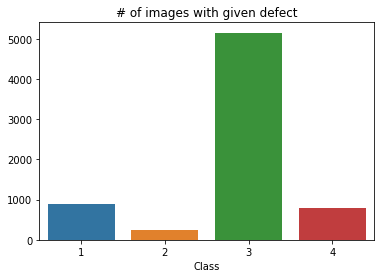

In [24]:
fig, ax = plt.subplots()
sns.barplot(x=list(defects_count.keys()), y=list(defects_count.values()), ax=ax)
ax.set_title("# of images with given defect")
ax.set_xlabel('Class')

Text(0.5, 0, '# of defects')

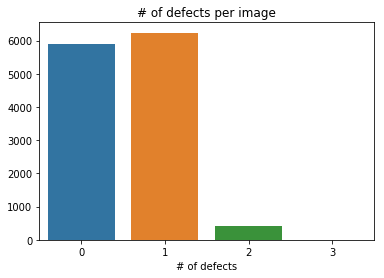

In [25]:
fig, ax = plt.subplots()
sns.barplot(x=list(num_of_defects_in_image.keys()), y=list(num_of_defects_in_image.values()), ax=ax)
ax.set_title("# of defects per image")
ax.set_xlabel('# of defects')

## Experiments with different models

In [31]:
import torchvision.models as models

In [32]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/krzysiek/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 29778805.97it/s]


In [33]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model